<img src="logo_MNA.png"></a>

<a href="https://maestriasydiplomados.tec.mx/posgrados/maestria-en-inteligencia-artificial-aplicada"><img src="logo_MR4010.png"></a>
<h1> <div align="center"> Dr. David Antonio-Torres</div> </h1>

# DETECCION DE PEATONES CON HOG Y SVM


En este trabajo, se desarrollará un modelo basado en máquinas de vectores de soporte (SVM) que permitirá identificar la presencia de peatones en imágenes. Este enfoque se ha seleccionado por su eficacia en la clasificación de datos y su capacidad para manejar grandes volúmenes de información con alta precisión.

Para llevar a cabo este proyecto, se utilizará el conjunto de datos proporcionado por el Daimler Pedestrian Benchmark Dataset, disponible en este enlace: http://www.gavrila.net/Datasets/Daimler_Pedestrian_Benchmark_D/Daimler_Mono_Ped__Class__Bench/daimler_mono_ped__class__bench.html. 

Este dataset incluye un total de 4800 muestras de peatones y 5000 muestras de no peatones por conjunto, todas recortadas de imágenes de vídeo y escaladas a un tamaño uniforme de 18x36 píxeles en escala de grises.

A continuación, se presenta una tabla que detalla los conjuntos de datos utilizados en esta investigación.

| Dataset Name | Purpose  | Pedestrian Labels | Pedestrian Examples | Non-ped. Examples | Storage Size |
|--------------|----------|-------------------|---------------------|-------------------|--------------|
| "1"          | Training | 800               | 4800                | 5000              | 39 MB        |
| "2"          | Training | 800               | 4800                | 5000              | 39 MB        |
| "3"          | Training | 800               | 4800                | 5000              | 39 MB        |
| "T1"         | Test     | 800               | 4800                | 5000              | 39 MB        |
| "T2"         | Test     | 800               | 4800                | 5000              | 39 MB        |

Debido al costo computacional se emplearan 10000 imágenes por clase.


# Se cargan las bibliotecas necesarias

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog
import os

# Se importan los dos datasets 
### https://docs.python.org/3/library/glob.html

In [2]:
import glob
pedestrian = glob.glob("DC-ped-dataset_base/**/ped_examples/*.pgm")
no_pedestrian = glob.glob("DC-ped-dataset_base/**/non-ped_examples/*.pgm")  

In [3]:
#Desplegamos la longitud de la variable pedestrian, que contiene 24,0000 imagenes.
len(pedestrian)

24000

In [4]:
#Desplegamos la longitud de la variable no_pedestrian, que contiene 25,0000 imagenes.
len(no_pedestrian)

25000

# Se muestra una imagen con un peaton

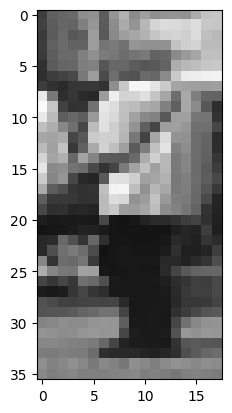

In [5]:
# Imprimimos una de las imágenes.
# Como se aprecia, la imagen ya se encuentra por defecto en gris. Por lo que no será necesario
# una conversión, eso nos ayudará a reducir los tiempos de procesamiento.

img_color = cv2.imread(pedestrian[10])
plt.imshow(img_color)

# Para fines de demostración se calcula el HOG de la imagen

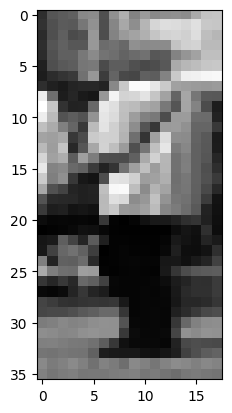

In [6]:
# Aseguramos que todas las imágenes se encuentren en formato de grises, a partir de la instrucción BGR2GRAY.
# Desplegamos la imagen.

img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap="gray")

In [7]:
# Calculamos el descriptor de Histogramas de Gradientes Orientados de la imagen.
# La imagen que ingresa está en escala de grises.
# Orientations: Nuestras imágenes son pequeñas, por lo que la detección de pequeños y finos detalles es importante.
# De manera típica, el número de orientaciones está entre 9 y 11; optaremos por 11.
# Pixels per cell: El tamaño de la celda escogido es de 6x6 píxeles, la imagen se divide en celdas. De ellas se obtiene el histograma de gradientes local.
# Cells per block: Se especifica el número de celdas por bloque; para este caso, cada bloque tiene dos celdas.
# transform_sqrt: Se evita la transformación de raíz cuadrada a la imagen, antes del cálculo de gradientes.
# visualize: Regresa una imagen del histograma de gradientes orientados, además de sus características (features).
# feature_vector: Nos regresa una matriz unidimensional.

features,hog_img = hog(img_gray,
                       orientations = 11,
                       pixels_per_cell = (6,6),
                       cells_per_block = (2,2),
                       transform_sqrt = False,
                       visualize = True,
                       feature_vector = True)

In [8]:
#Obtenemos la dimension del vector de características HOG de la imagen
features.shape

(440,)

In [9]:
# Obtenemos la dimensión de la imagen de los histogramas de gradientes orientados.
hog_img.shape

(36, 18)

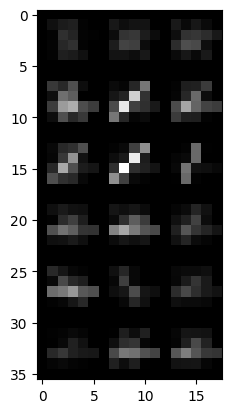

In [10]:
# Se imprime la variable que contiene la imagen de los HOGs.
plt.imshow(hog_img,cmap = 'gray')

# Funciones

In [11]:
def process_image(dir, size=(18, 36), rgb2gray=True):
    """
    Importa una imagen, redimensionándola y convirtiéndola a escala de grises si es necesario.

    Args:
    - dir: Ruta de la imagen a procesar.
    - size: Tupla que especifica el nuevo tamaño deseado de la imagen. Por defecto, (36, 18).
    - rgb2gray: Booleano que indica si se debe convertir la imagen a escala de grises. Por defecto, True.

    Returns:
    - La imagen procesada.
    """
    image = cv2.imread(dir)
    # Obtener las dimensiones de la imagen
    y, x, z = image.shape

    # Convertir a escala de grises si rgb2gray es verdadero
    if rgb2gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Redimensionar la imagen si el tamaño no coincide con el especificado
    if (x, y) != size:
        image = cv2.resize(image, size)

    return image

In [12]:
def calculate_hog(image, block_size=(6, 6), cell_size=(2, 2), nbins=9):
    """
    Calcula el descriptor HOG de una imagen.

    Parámetros:
        image (array): La imagen de entrada.
        block_size (tuple): Tamaño del bloque en el que se divide la ventana deslizante. Por defecto, (6, 6).
        cell_size (tuple): Tamaño de la celda dentro de cada bloque. Por defecto, (2, 2).
        nbins (int): Número de bins en el histograma de gradientes orientados. Por defecto, 9.

    Retorna:
        hog_features (array): El descriptor HOG de la imagen.
    """
    # Calcula el descriptor HOG
    hog_features = hog(image, orientations=nbins, pixels_per_cell=block_size,
                       cells_per_block=cell_size, block_norm='L2-Hys', visualize=False)
    
    return hog_features

# Se extraen las features del HOG para ambos tipos de datos

En la siguiente parte se importaran las imagenes, a las cuales se les aplicaran un re-escalado de imagen y conversión a escala de grises mediante la función 'process_image()', así como la reducción de ambas clases a 10000 ejemplos por clase debido a que emplear 25000 imagenes por clase requiere mayor costo computacional, debido a esto el valor de max_samples se establece en 10000.

In [13]:
max_samples = 10000      # maximo de imágenes a emplear por clase

In [14]:
# Procesamiento de las imágenes de peatones
pedestrian_img = [process_image(img, rgb2gray=True) for img in pedestrian[:max_samples]]

# Calcula el descriptor HOG para las imágenes de la clase positiva (peatones)
pedestrian_hog_accum = [calculate_hog(image) for image in pedestrian_img]

In [15]:
# Comenzamos el apilamiento vertical de la lista pedestrian_hog_acum y se asigna a X_pedestrian.
X_pedestrian = np.vstack(pedestrian_hog_accum).astype(np.float64)
# Creamos una variable llamada y_pedestrian que indicará cuando se detectaron peatones.
# Esta tendrá una longitud igual a la longitud de x_pedestrian.
y_pedestrian = np.ones(len(X_pedestrian))

In [16]:
#Se obtienen las dimensiones de X_pedestrian.
X_pedestrian.shape

(10000, 360)

In [17]:
#Se obtienen las dimensiones de y_pedestrian.
y_pedestrian.shape

(10000,)

In [18]:
# Procesamiento de las imágenes no peatonales.
nopedestrian_img = [process_image(img, rgb2gray=True) for img in no_pedestrian[:max_samples]]

# Calcula el descriptor HOG para las imágenes de la clase negativa (sin peatones).
nopedestrian_hog_accum = [calculate_hog(image) for image in nopedestrian_img]

In [19]:
# Realizamos nuevamente el apilamiento vertical pero ahora sobre la variable no_pedestrian_hog_acum.
# Creamos una variable y_no_pedestrian que será de la misma longitud que X_no_pedestrian pero llena de ceros, indicando que no hubo peatón.
X_nopedestrian = np.vstack(nopedestrian_hog_accum).astype(np.float64)
y_nopedestrian = np.zeros(len(X_nopedestrian))

In [20]:
#Se imprimen las dimensiones de X_nopedestrian.
X_nopedestrian.shape

(10000, 360)

In [21]:
#Se imprimen las dimensiones de y_nopedestrian.
y_nopedestrian.shape

(10000,)

# Se combinan ambos tipos de datos para alimentar el SVM

In [22]:
# Realizamos el apilamiento vertical de nuestras dos variables independientes, que contienen los descriptores de ambas clasificaciones;
# cuando hay peatones y cuando no hay peatones.
# Imprimimos la dimensión de nuestra X.
X = np.vstack((X_pedestrian,X_nopedestrian))
X.shape

(20000, 360)

In [23]:
# Se hace el apilamiento de las salidas cuando se detectaron peatones y cuando no se detectaron peatones.
y = np.hstack((y_pedestrian,y_nopedestrian))
y.shape

(20000,)

# Se generan los datos de entrenamiento y de prueba

En esta seccion se divide el conjunto de entrenamiento y pruebas en un 70%-30%

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Mostramos las dimesiones del conjunto de entrenamiento.

In [25]:
X_train.shape

(16000, 360)

Mostramos las dimesiones del conjunto de prueba.

In [26]:
X_test.shape

(4000, 360)

A continuación, usando Sklearn, se usará el modelo SVM para 2 modelos uno sin ajuste de hiperparámetros y otro con ajuste de hiperparámetros empleando gridsearch para obtener el mejor modelo posible.

# Se importa el Clasificador y se entrena

# Red neuronal

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


2024-05-28 18:49:29.857614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [56]:
from sklearn.preprocessing import StandardScaler
# Estandarizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
model = Sequential()
model.add(Dense(70, input_dim=X_train.shape[1], activation='relu'))  # Capa oculta con 16 neuronas
model.add(Dense(50, activation='relu'))  # Otra capa oculta con 8 neuronas
model.add(Dense(40, activation='relu'))  # Otra capa oculta con 8 neuronas
model.add(Dense(30, activation='relu'))  # Otra capa oculta con 8 neuronas
model.add(Dense(30, activation='relu'))  # Otra capa oculta con 8 neuronas
model.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])   

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
history = model.fit(x=X_train, y=y_train, verbose=2, batch_size=800,epochs=80, shuffle=True)

Epoch 1/80
20/20 - 3s - 175ms/step - accuracy: 0.8283 - loss: 0.3474
Epoch 2/80
20/20 - 0s - 13ms/step - accuracy: 0.9452 - loss: 0.1415
Epoch 3/80
20/20 - 0s - 10ms/step - accuracy: 0.9666 - loss: 0.0934
Epoch 4/80
20/20 - 0s - 11ms/step - accuracy: 0.9779 - loss: 0.0661
Epoch 5/80
20/20 - 0s - 11ms/step - accuracy: 0.9835 - loss: 0.0466
Epoch 6/80
20/20 - 0s - 11ms/step - accuracy: 0.9827 - loss: 0.0463
Epoch 7/80
20/20 - 0s - 13ms/step - accuracy: 0.9870 - loss: 0.0378
Epoch 8/80
20/20 - 0s - 15ms/step - accuracy: 0.9899 - loss: 0.0277
Epoch 9/80
20/20 - 0s - 19ms/step - accuracy: 0.9937 - loss: 0.0201
Epoch 10/80
20/20 - 0s - 9ms/step - accuracy: 0.9949 - loss: 0.0159
Epoch 11/80
20/20 - 0s - 8ms/step - accuracy: 0.9932 - loss: 0.0205
Epoch 12/80
20/20 - 0s - 8ms/step - accuracy: 0.9935 - loss: 0.0186
Epoch 13/80
20/20 - 0s - 11ms/step - accuracy: 0.9933 - loss: 0.0179
Epoch 14/80
20/20 - 0s - 10ms/step - accuracy: 0.9971 - loss: 0.0087
Epoch 15/80
20/20 - 0s - 13ms/step - accuracy

In [59]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9543 - loss: 0.6191
Accuracy: 95.32%


In [60]:
from sklearn.metrics import classification_report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      1981
         1.0       0.95      0.96      0.95      2019

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



# Gracias por la atención